<a href="https://colab.research.google.com/github/Jesteban247/ML-College/blob/main/Fund_%20ML/Projects/Project_1/Part_1/Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required libraries

In [ ]:
!pip install git+https://github.com/m0rp43us/openmeteopy

# Import necessary libraries

In [1]:
import requests
import pandas as pd
import os
#from openmeteopy import OpenMeteo
#from openmeteopy.hourly import HourlyHistorical, HourlyAirQuality
#from openmeteopy.daily import DailyHistorical
#from openmeteopy.options import HistoricalOptions, AirQualityOptions
from tqdm import tqdm
from google.colab import drive
from datetime import datetime
from google.colab import userdata
import time
import csv

# Set Constants

In [ ]:
# Constants
API_KEY= userdata.get('API_KEY') # https://countrystatecity.in/
BASE_URL = "https://api.countrystatecity.in/v1"
HEADERS = {'X-CSCAPI-KEY': API_KEY}
COUNTRIES_LIST = [
    "Akrotiri and Dhekelia", "Bahrain", "Cyprus", "Egypt", "Iran", "Iraq",
    "Israel", "Jordan", "Kuwait", "Lebanon", "Oman", "Palestinian Territory Occupied",
    "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates", "Yemen", "India"
]

# Section 1: Creating Data Base

## Fetch Country Data

In [ ]:
# Function to fetch countries
def fetch_countries():
    response = requests.get(f"{BASE_URL}/countries", headers=HEADERS)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    print(f"Error fetching countries: {response.status_code}")
    return pd.DataFrame()

In [ ]:
# Fetch countries data
countries_df = fetch_countries()
countries_df.head()

,id,name,iso2,iso3,phonecode,capital,currency,native,emoji
0,1,Afghanistan,AF,AFG,93,Kabul,AFN,افغانستان,🇦🇫
1,2,Aland Islands,AX,ALA,+358-18,Mariehamn,EUR,Åland,🇦🇽
2,3,Albania,AL,ALB,355,Tirana,ALL,Shqipëria,🇦🇱
3,4,Algeria,DZ,DZA,213,Algiers,DZD,الجزائر,🇩🇿
4,5,American Samoa,AS,ASM,+1-684,Pago Pago,USD,American Samoa,🇦🇸


## Filter for Relevant Countries

In [ ]:
# Function to filter countries of interest
def filter_countries(df_countries):
    selected_countries = df_countries[df_countries['name'].isin(COUNTRIES_LIST)]
    missing_countries = set(COUNTRIES_LIST) - set(selected_countries['name'])
    print("Missing countries:", missing_countries)
    return selected_countries

In [ ]:
# Filter countries of interest
filtered_countries = filter_countries(countries_df)
filtered_countries.head()

Missing countries: {'Akrotiri and Dhekelia'}


,id,name,iso2,iso3,phonecode,capital,currency,native,emoji
17,18,Bahrain,BH,BHR,973,Manama,BHD,‏البحرين,🇧🇭
56,57,Cyprus,CY,CYP,357,Nicosia,EUR,Κύπρος,🇨🇾
64,65,Egypt,EG,EGY,20,Cairo,EGP,مصر‎,🇪🇬
100,101,India,IN,IND,91,New Delhi,INR,भारत,🇮🇳
102,103,Iran,IR,IRN,98,Tehran,IRR,ایران,🇮🇷


## Fetch States Data

In [ ]:
# Function to fetch states by country
def fetch_states(country_iso2):
    response = requests.get(f"{BASE_URL}/countries/{country_iso2}/states", headers=HEADERS)
    return response.json() if response.status_code == 200 else []

# Function to get all states data for selected countries
def get_states_data(selected_countries):
    states_data = []
    for _, country in tqdm(selected_countries.iterrows(), desc="Fetching states", total=len(selected_countries)):
        states = fetch_states(country['iso2'])
        for state in states:
            states_data.append({
                'country_name': country['name'],
                'country_iso2': country['iso2'],
                'state_id': state['id'],
                'state_name': state['name'],
                'state_iso2': state['iso2']
            })
    return pd.DataFrame(states_data)

In [ ]:
# Fetch states data
states_df = get_states_data(filtered_countries)
states_df.head()

Fetching states: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


,country_name,country_iso2,state_id,state_name,state_iso2
0,Bahrain,BH,1992,Capital,13
1,Bahrain,BH,1993,Southern,14
2,Bahrain,BH,1994,Northern,17
3,Bahrain,BH,1995,Muharraq,15
4,Bahrain,BH,1996,Central,16


## Fetch Cities Data

In [ ]:
# Function to fetch cities by state
def fetch_cities(country_iso2, state_iso2):
    response = requests.get(f"{BASE_URL}/countries/{country_iso2}/states/{state_iso2}/cities", headers=HEADERS)
    return response.json() if response.status_code == 200 else []

# Function to get all cities data for selected states
def get_cities_data(states_df):
    cities_data = []
    for _, state in tqdm(states_df.iterrows(), desc="Fetching cities", total=len(states_df)):
        cities = fetch_cities(state['country_iso2'], state['state_iso2'])
        for city in cities:
            cities_data.append({
                'country_name': state['country_name'],
                'country_iso2': state['country_iso2'],
                'state_id': state['state_id'],
                'state_name': state['state_name'],
                'city_id': city['id'],
                'city_name': city['name'],
                'latitude': float(city.get('latitude', 'nan')),
                'longitude': float(city.get('longitude', 'nan'))
            })
    return pd.DataFrame(cities_data)

In [ ]:
# Fetch cities data
cities_df = get_cities_data(states_df)
cities_df

In [ ]:
# Save cities data to CSV
cities_df.to_csv('/content/drive/MyDrive/cities_data.csv', sep=';', index=False)

## Fetch air quality and weather data,

In [ ]:
def process_city_data_to_csv(cities_df, start_row, date_str, output_path):
    batch_size = 100
    total_rows = len(cities_df)

    while start_row < total_rows:
        if start_row + batch_size > total_rows:
            batch_size = total_rows - start_row  # Adjust the batch size for the last portion

        batch = cities_df.iloc[start_row:start_row + batch_size]

        # Collect data for each city in the current batch
        batch_data = []
        for _, row in batch.iterrows():
            try:
                city_data = get_city_daily_averages_as_dict(row, date_str)
                if city_data:  # Only append if city_data is not empty
                    batch_data.append(city_data)
            except Exception as e:
                print(f"Error processing data for {row['city_name']}: {e}")
                continue

        # Only write to CSV if there's data to write
        if batch_data:
            write_batch_to_csv(batch_data, output_path)
            print(f"Batch starting at row {start_row} with {len(batch_data)} rows written to CSV.")

        # Update the start row to the next batch
        start_row += batch_size


def get_city_daily_averages_as_dict(row, date_str):
    latitude = row['latitude']
    longitude = row['longitude']
    date_obj = datetime.strptime(date_str, '%d/%m/%Y')
    formatted_date = date_obj.strftime('%Y-%m-%d')

    result = {
        "country_name": row['country_name'],
        "country_iso2": row['country_iso2'],
        "state_id": row['state_id'],
        "state_name": row['state_name'],
        "city_id": row['city_id'],
        "city_name": row['city_name'],
        "latitude": latitude,
        "longitude": longitude,
        "date": formatted_date,
    }

    try:
        air_quality_data = fetch_air_quality_data(latitude, longitude, formatted_date)
        air_quality_template = [
            'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone',
            'aerosol_optical_depth', 'dust', 'uv_index', 'uv_index_clear_sky', 'ammonia',
            'alder_pollen', 'birch_pollen', 'grass_pollen', 'mugwort_pollen', 'olive_pollen',
            'ragweed_pollen', 'european_aqi', 'european_aqi_pm2_5', 'european_aqi_pm10',
            'european_aqi_no2', 'european_aqi_o3', 'european_aqi_so2', 'us_aqi',
            'us_aqi_pm2_5', 'us_aqi_pm10', 'us_aqi_no2', 'us_aqi_co', 'us_aqi_o3', 'us_aqi_so2'
        ]

        air_quality_averages = air_quality_data.mean()
        result.update({f"AirPollution_{key}": air_quality_averages.get(key, None) for key in air_quality_template})

        # Fetch weather data
        weather_data = fetch_weather_data(latitude, longitude, formatted_date)
        weather_template = [
            'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature', 'pressure_msl',
            'surface_pressure', 'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
            'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m',
            'windgusts_10m', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
            'vapor_pressure_deficit', 'et0_fao_evapotranspiration', 'precipitation', 'weathercode',
            'snowfall', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
            'soil_moisture_100_to_255cm', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
            'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm'
        ]

        weather_averages = weather_data.mean()
        result.update({f"Weather_{key}": weather_averages.get(key, None) for key in weather_template})

    except Exception as e:
        print(f"Error fetching data for {row['city_name']} on {formatted_date}: {e}")
        return None  # Return None if any error occurs during data fetching

    return result

def fetch_air_quality_data(latitude, longitude, date):
    try:
        hourly_air_quality = HourlyAirQuality()
        air_quality_options = AirQualityOptions(latitude, longitude)
        air_quality_options.start = date
        air_quality_options.end = date
        air_quality_mgr = OpenMeteo(air_quality_options, hourly_air_quality.all())
        return air_quality_mgr.get_pandas()
    except Exception as e:
        print(f"API call for air quality data failed: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

def fetch_weather_data(latitude, longitude, date):
    try:
        hourly_weather = HourlyHistorical()
        weather_options = HistoricalOptions(latitude, longitude, start_date=date, end_date=date)
        weather_mgr = OpenMeteo(weather_options, hourly_weather.all())
        return weather_mgr.get_pandas()
    except Exception as e:
        print(f"API call for weather data failed: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

def write_batch_to_csv(batch_data, output_path):
    write_header = not pd.io.common.file_exists(output_path)

    with open(output_path, mode='a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=batch_data[0].keys(), delimiter=';', extrasaction='ignore')
        if write_header:
            writer.writeheader()
        writer.writerows(batch_data)

In [ ]:
# Load cities_data.csv if necessary
cities_df = pd.read_csv('/content/drive/MyDrive/cities_data.csv', sep=';')
cities_df

,country_name,country_iso2,state_id,state_name,state_iso2,city_id,city_name,latitude,longitude
0,Bahrain,BH,1992,Capital,13,9757,Jidd Ḩafş,26.21861,50.54778
1,Bahrain,BH,1992,Capital,13,9760,Manama,26.22787,50.58565
2,Bahrain,BH,1992,Capital,13,9761,Sitrah,26.15472,50.62056
3,Bahrain,BH,1993,Southern,14,9755,Ar Rifā‘,26.13000,50.55500
4,Bahrain,BH,1993,Southern,14,9756,Dār Kulayb,26.06861,50.50389
...,...,...,...,...,...,...,...,...,...
8658,Yemen,YE,1251,Al Mahrah,MR,130870,Huswain,15.72300,51.91240
8659,Yemen,YE,1251,Al Mahrah,MR,130908,Man'ar,16.55050,50.98790
8660,Yemen,YE,1251,Al Mahrah,MR,130943,Qishn,15.69990,51.32400
8661,Yemen,YE,1251,Al Mahrah,MR,130968,Sayhut,15.53450,51.28690


In [ ]:
# Path for the output CSV file
output_path = '/content/drive/MyDrive/final.csv'

# Process city data to CSV starting from row x
process_city_data_to_csv(cities_df, start_row=7800, date_str='1/10/2024', output_path=output_path)

Batch starting at row 7800 with 100 rows written to CSV.
Batch starting at row 7900 with 100 rows written to CSV.
Batch starting at row 8000 with 100 rows written to CSV.
Batch starting at row 8100 with 100 rows written to CSV.
Batch starting at row 8200 with 100 rows written to CSV.
Batch starting at row 8300 with 100 rows written to CSV.
Batch starting at row 8400 with 100 rows written to CSV.
Batch starting at row 8500 with 100 rows written to CSV.
Batch starting at row 8600 with 63 rows written to CSV.


In [ ]:
# Verify final CSV content
df = pd.read_csv('/content/drive/MyDrive/final.csv', sep=';')
df

,country_name,country_iso2,state_id,state_name,city_id,city_name,latitude,longitude,date,AirPollution_pm10,...,Weather_weathercode,Weather_snowfall,Weather_soil_moisture_0_to_7cm,Weather_soil_moisture_7_to_28cm,Weather_soil_moisture_28_to_100cm,Weather_soil_moisture_100_to_255cm,Weather_soil_temperature_0_to_7cm,Weather_soil_temperature_7_to_28cm,Weather_soil_temperature_28_to_100cm,Weather_soil_temperature_100_to_255cm
0,Bahrain,BH,1992,Capital,9757,Jidd Ḩafş,26.21861,50.54778,2024-10-01,68.353333,...,0.000,0.0,0.010000,0.113,0.052000,0.000,37.083333,36.541667,36.800000,32.5000
1,Bahrain,BH,1992,Capital,9760,Manama,26.22787,50.58565,2024-10-01,68.353333,...,0.000,0.0,0.000000,0.000,0.000000,0.000,31.620833,31.625000,31.625000,31.6250
2,Bahrain,BH,1992,Capital,9761,Sitrah,26.15472,50.62056,2024-10-01,64.589167,...,0.000,0.0,0.000000,0.000,0.000000,0.000,31.837500,31.837500,31.837500,31.8375
3,Bahrain,BH,1993,Southern,9755,Ar Rifā‘,26.13000,50.55500,2024-10-01,66.263333,...,0.000,0.0,0.010000,0.111,0.055000,0.096,37.062500,36.679167,36.500000,33.5000
4,Bahrain,BH,1993,Southern,9756,Dār Kulayb,26.06861,50.50389,2024-10-01,66.263333,...,0.000,0.0,0.010000,0.110,0.086000,0.122,36.325000,35.875000,35.933333,34.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8658,Yemen,YE,1251,Al Mahrah,130870,Huswain,15.72300,51.91240,2024-10-01,19.317500,...,47.000,0.0,0.069083,0.135,0.192042,0.192,29.150000,31.600000,33.175000,32.6000
8659,Yemen,YE,1251,Al Mahrah,130908,Man'ar,16.55050,50.98790,2024-10-01,232.314167,...,1.125,0.0,0.013833,0.108,0.120000,0.165,32.383333,33.087500,34.016667,33.2000
8660,Yemen,YE,1251,Al Mahrah,130943,Qishn,15.69990,51.32400,2024-10-01,133.481667,...,1.125,0.0,0.019792,0.124,0.175708,0.176,31.995833,32.558333,33.000000,32.7000
8661,Yemen,YE,1251,Al Mahrah,130968,Sayhut,15.53450,51.28690,2024-10-01,133.481667,...,15.750,0.0,0.024000,0.127,0.160000,0.175,30.454167,31.420833,32.095833,31.0000


# Section 2: SVD

## Data Loading

In [65]:
# Load Data Base
df = pd.read_csv('/content/drive/MyDrive/final.csv', sep=';')
df

,country_name,country_iso2,state_id,state_name,city_id,city_name,latitude,longitude,date,AirPollution_pm10,...,Weather_weathercode,Weather_snowfall,Weather_soil_moisture_0_to_7cm,Weather_soil_moisture_7_to_28cm,Weather_soil_moisture_28_to_100cm,Weather_soil_moisture_100_to_255cm,Weather_soil_temperature_0_to_7cm,Weather_soil_temperature_7_to_28cm,Weather_soil_temperature_28_to_100cm,Weather_soil_temperature_100_to_255cm
0,Bahrain,BH,1992,Capital,9757,Jidd Ḩafş,26.21861,50.54778,2024-10-01,68.353333,...,0.000,0.0,0.010000,0.113,0.052000,0.000,37.083333,36.541667,36.800000,32.5000
1,Bahrain,BH,1992,Capital,9760,Manama,26.22787,50.58565,2024-10-01,68.353333,...,0.000,0.0,0.000000,0.000,0.000000,0.000,31.620833,31.625000,31.625000,31.6250
2,Bahrain,BH,1992,Capital,9761,Sitrah,26.15472,50.62056,2024-10-01,64.589167,...,0.000,0.0,0.000000,0.000,0.000000,0.000,31.837500,31.837500,31.837500,31.8375
3,Bahrain,BH,1993,Southern,9755,Ar Rifā‘,26.13000,50.55500,2024-10-01,66.263333,...,0.000,0.0,0.010000,0.111,0.055000,0.096,37.062500,36.679167,36.500000,33.5000
4,Bahrain,BH,1993,Southern,9756,Dār Kulayb,26.06861,50.50389,2024-10-01,66.263333,...,0.000,0.0,0.010000,0.110,0.086000,0.122,36.325000,35.875000,35.933333,34.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8658,Yemen,YE,1251,Al Mahrah,130870,Huswain,15.72300,51.91240,2024-10-01,19.317500,...,47.000,0.0,0.069083,0.135,0.192042,0.192,29.150000,31.600000,33.175000,32.6000
8659,Yemen,YE,1251,Al Mahrah,130908,Man'ar,16.55050,50.98790,2024-10-01,232.314167,...,1.125,0.0,0.013833,0.108,0.120000,0.165,32.383333,33.087500,34.016667,33.2000
8660,Yemen,YE,1251,Al Mahrah,130943,Qishn,15.69990,51.32400,2024-10-01,133.481667,...,1.125,0.0,0.019792,0.124,0.175708,0.176,31.995833,32.558333,33.000000,32.7000
8661,Yemen,YE,1251,Al Mahrah,130968,Sayhut,15.53450,51.28690,2024-10-01,133.481667,...,15.750,0.0,0.024000,0.127,0.160000,0.175,30.454167,31.420833,32.095833,31.0000


## Data Preprocessing

In [ ]:
# See null values by columns
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

# Delete the columns with null values
df = df.dropna(axis=1)

In [67]:
# Display columns' information
for column in df.columns:
    print(f"Column: {column}, Type: {df[column].dtype}")

Column: country_name, Type: object
Column: country_iso2, Type: object
Column: state_id, Type: int64
Column: state_name, Type: object
Column: city_id, Type: int64
Column: city_name, Type: object
Column: latitude, Type: float64
Column: longitude, Type: float64
Column: date, Type: object
Column: AirPollution_pm10, Type: float64
Column: AirPollution_pm2_5, Type: float64
Column: AirPollution_carbon_monoxide, Type: float64
Column: AirPollution_nitrogen_dioxide, Type: float64
Column: AirPollution_sulphur_dioxide, Type: float64
Column: AirPollution_ozone, Type: float64
Column: AirPollution_aerosol_optical_depth, Type: float64
Column: AirPollution_dust, Type: float64
Column: AirPollution_uv_index, Type: float64
Column: AirPollution_uv_index_clear_sky, Type: float64
Column: AirPollution_european_aqi, Type: float64
Column: AirPollution_european_aqi_pm2_5, Type: float64
Column: AirPollution_european_aqi_pm10, Type: float64
Column: AirPollution_european_aqi_no2, Type: float64
Column: AirPollution_e

In [68]:
# Copy the DataFrame for PCA
PCA_df = df.copy()

# Drop unnecessary columns for PCA
PCA_df = PCA_df.drop(['country_name', 'country_iso2', 'state_id', 'state_name',
                      'city_id', 'city_name', 'latitude', 'longitude', 'date'], axis=1)

# Set index for PCA
PCA_df['index'] = df['country_iso2'] + '-' + df['city_name']
PCA_df = PCA_df.set_index('index')

# Count the zeros in each column and drop columns with more than 1000 zeros
zero_counts = (PCA_df == 0).sum()
columns_to_drop = zero_counts[zero_counts > 1000].index.tolist()
PCA_df = PCA_df.drop(columns=columns_to_drop)

# See the dimensions of PCA_df
print("Dimensions of PCA_df:", PCA_df.shape)

Dimensions of PCA_df: (8663, 48)


In [95]:
# Save the processed DataFrame to CSV
PCA_df.to_csv('/content/PCA_df.csv', sep=',', index=False)

## R Environment Setup

In [71]:
# Install rpy2
!pip install rpy2

In [72]:
# Load R extension
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## PCA Implementation in R (Basic example)

### Without Libs

In [73]:
%%R

PCA_df <- read.csv('/content/PCA_df.csv')

# Manually creating the dataset
data <- matrix(c(
    1.2852880,  1.4250020, -1.9572635, -0.042863874,  1.4242696,
   -0.5734950,  1.2522317,  0.3383886,  0.830070224, -0.7367132,
    0.3174834, -1.0127756,  1.1619263,  0.006909911,  0.1699205,
    0.5765053,  2.1411438,  2.0352826,  0.801343804,  0.1636263,
    0.3569895, -0.6406842, -1.3436351, -0.204758665, -0.4514990,
   -0.1331333,  0.2134519, -1.1214097, -0.103656731, -0.8636425
), nrow = 6, byrow = TRUE)

# Print the first few rows of the generated data
cat("Generated Data:\n")
print(head(data))

# Scale the data
data <- scale(data)

# Calculate Covariance Matrix
Sigma <- cov(data)  # Covariance matrix
cat("\nCovariance Matrix:\n")
print(Sigma)

# Eigenvalue decomposition
eigen_result <- eigen(Sigma)  # Perform eigen decomposition
eigen_values <- eigen_result$values  # Eigenvalues
eigen_vectors <- eigen_result$vectors  # Eigenvectors (loadings)

# Print Eigenvalues and Eigenvectors
cat("\nEigenvalues:\n")
print(eigen_values)
cat("\nEigenvectors (Loadings):\n")
print(eigen_vectors)

# Calculate Principal Components (Y)
Y <- data %*% eigen_vectors  # Project original data onto principal component space
cat("\nPrincipal Components (Y):\n")
print(head(Y))  # Print the first few rows of the principal components

# Calculate Cumulative Proportion of Variance
Cumulative_Proportion <- cumsum(eigen_values / sum(eigen_values))  # Cumulative proportion
cat("\nCumulative Proportion of Variance:\n")
print(Cumulative_Proportion)

Generated Data:
           [,1]       [,2]       [,3]         [,4]       [,5]
[1,]  1.2852880  1.4250020 -1.9572635 -0.042863874  1.4242696
[2,] -0.5734950  1.2522317  0.3383886  0.830070224 -0.7367132
[3,]  0.3174834 -1.0127756  1.1619263  0.006909911  0.1699205
[4,]  0.5765053  2.1411438  2.0352826  0.801343804  0.1636263
[5,]  0.3569895 -0.6406842 -1.3436351 -0.204758665 -0.4514990
[6,] -0.1331333  0.2134519 -1.1214097 -0.103656731 -0.8636425

Covariance Matrix:
           [,1]      [,2]       [,3]       [,4]       [,5]
[1,]  1.0000000 0.1874673 -0.2467005 -0.3480945  0.9156653
[2,]  0.1874673 1.0000000  0.1976147  0.7058162  0.2958567
[3,] -0.2467005 0.1976147  1.0000000  0.6978246 -0.1468517
[4,] -0.3480945 0.7058162  0.6978246  1.0000000 -0.1484952
[5,]  0.9156653 0.2958567 -0.1468517 -0.1484952  1.0000000

Eigenvalues:
[1] 2.29795283 1.92127452 0.66350820 0.09673587 0.02052858

Eigenvectors (Loadings):
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,] -0.5108547 -

### With libs

In [74]:
%%R

# Centering and scaling the data
pca_result <- prcomp(data, center = TRUE, scale. = TRUE)

# Print the results
cat("\nPrincipal Components (PCs):\n")
print(head(pca_result$x))  # Principal components

cat("\nStandard Deviations of Principal Components:\n")
print(pca_result$sdev)  # Standard deviations (square roots of eigenvalues)

cat("\nProportion of Variance:\n")
prop_variance <- (pca_result$sdev^2) / sum(pca_result$sdev^2)
print(prop_variance)  # Proportion of variance explained by each component

cat("\nCumulative Proportion of Variance:\n")
cumulative_proportion <- cumsum(prop_variance)  # Cumulative proportion
print(cumulative_proportion)  # Cumulative proportion of variance explained

cat("\nLoadings (Eigenvectors):\n")
print(pca_result$rotation)  # Loadings (eigenvectors)


Principal Components (PCs):
             PC1         PC2         PC3        PC4         PC5
[1,] -2.24492033  1.48233347 -0.52521984  0.1849034  0.03529935
[2,]  2.02406490 -0.09126113 -0.65933198  0.3988061 -0.04057563
[3,] -0.21863912 -0.59569976  1.44784491  0.2234207  0.07659721
[4,]  1.24656112  1.86931179  0.37973806 -0.3695628 -0.02954206
[5,] -0.86497788 -1.30709050 -0.03887969 -0.1546829 -0.23552616
[6,]  0.05791131 -1.35759387 -0.60415146 -0.2828844  0.19374730

Standard Deviations of Principal Components:
[1] 1.5159000 1.3861005 0.8145601 0.3110239 0.1432780

Proportion of Variance:
[1] 0.459590566 0.384254903 0.132701640 0.019347175 0.004105715

Cumulative Proportion of Variance:
[1] 0.4595906 0.8438455 0.9765471 0.9958943 1.0000000

Loadings (Eigenvectors):
            PC1       PC2        PC3        PC4        PC5
[1,] -0.5108547 0.4212633  0.2135478 -0.4926139 -0.5227750
[2,]  0.1950646 0.5974669 -0.5639967 -0.3583320  0.3981068
[3,]  0.4680812 0.2289195  0.7646079 -0.2

## Perform PCA using the processed PCA_df DataFrame

In [96]:
%%R

# Read data
PCA_df <- read.csv('/content/PCA_df.csv')

pca_result <- prcomp(PCA_df, center = TRUE, scale. = TRUE)

# Save results to variables
pca <- pca_result$x  # Principal Components
stand <- pca_result$sdev  # Standard Deviations of Principal Components
prop_variance <- (stand^2) / sum(stand^2)  # Proportion of variance explained by each component
cumulative_proportion <- cumsum(prop_variance)  # Cumulative proportion
loadings <- pca_result$rotation  # Loadings (eigenvectors)

# Notify that results are saved to variables
cat("PCA results saved to variables.")

PCA results saved to variables.

In [97]:
# Display PCA summary
%%R
summary(pca_result)

Importance of components:
                         PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     3.769 2.8351 2.3727 2.1207 1.79749 1.55938 1.43044
Proportion of Variance 0.296 0.1675 0.1173 0.0937 0.06731 0.05066 0.04263
Cumulative Proportion  0.296 0.4634 0.5807 0.6744 0.74173 0.79239 0.83502
                           PC8     PC9    PC10    PC11   PC12    PC13    PC14
Standard deviation     1.28445 1.11187 1.03291 0.96528 0.7715 0.65670 0.55028
Proportion of Variance 0.03437 0.02576 0.02223 0.01941 0.0124 0.00898 0.00631
Cumulative Proportion  0.86939 0.89515 0.91738 0.93679 0.9492 0.95817 0.96448
                         PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.5410 0.47578 0.42937 0.39302 0.33658 0.30811 0.29857
Proportion of Variance 0.0061 0.00472 0.00384 0.00322 0.00236 0.00198 0.00186
Cumulative Proportion  0.9706 0.97529 0.97914 0.98235 0.98471 0.98669 0.98855
                          PC22    PC23    PC24    PC25

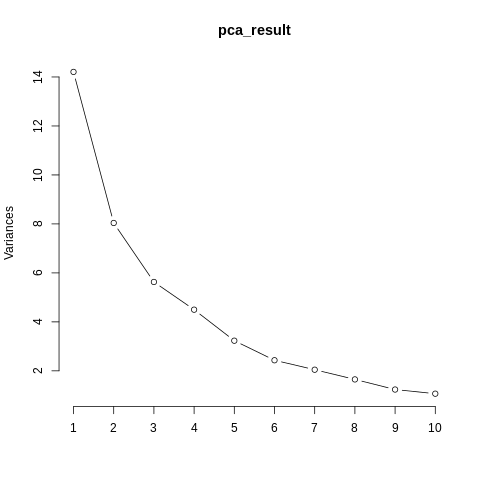

In [77]:
# Scree plot for variance explained
%%R
screeplot(pca_result, type="lines")

**Explanation for component selection**

In the analysis of the PCA results, it was determined that selecting the first 10 principal components (PCs) is justified based on their cumulative proportion of variance explained.
The cumulative proportion indicates that the first 10 PCs together account for approximately 91.74% of the total variance in the dataset.
This substantial representation suggests that these components capture the majority of the information contained within the original features while significantly reducing dimensionality.


In [84]:
%%R

# Loadings from PCA
loadings <- pca_result$rotation

# Select the first 10 PCs
selected_loadings <- loadings[, 1:10]

# Show it
selected_loadings

                                               PC1         PC2         PC3
AirPollution_pm10                     -0.184084497  0.06439617 -0.13267888
AirPollution_pm2_5                    -0.231409377 -0.07360179 -0.13016880
AirPollution_carbon_monoxide          -0.144167103 -0.05254211 -0.12818381
AirPollution_nitrogen_dioxide         -0.110082058  0.07000322 -0.17731477
AirPollution_sulphur_dioxide          -0.135129898  0.05333182 -0.13854719
AirPollution_ozone                    -0.067592876  0.04236370 -0.08509673
AirPollution_aerosol_optical_depth    -0.190922859 -0.15808489 -0.01042040
AirPollution_dust                     -0.077159185  0.14056818 -0.08735282
AirPollution_uv_index                 -0.013872724  0.19156190  0.22333945
AirPollution_uv_index_clear_sky       -0.008434989  0.07274741  0.32624778
AirPollution_european_aqi             -0.217307010  0.03332766 -0.12486621
AirPollution_european_aqi_pm2_5       -0.238465343 -0.07977356 -0.08951852
AirPollution_european_aqi

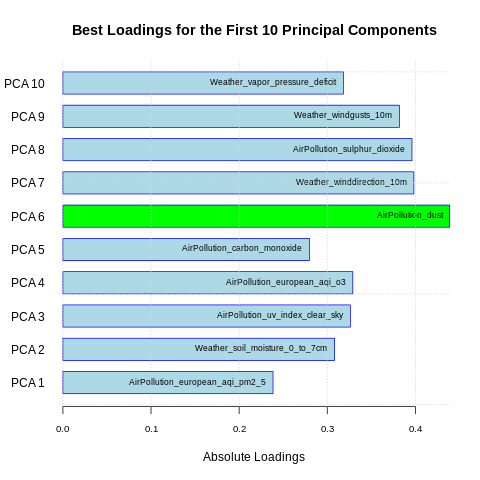

In [78]:
%%R

# Loadings from PCA
loadings <- pca_result$rotation

# Select the first 10 PCs
selected_loadings <- loadings[, 1:10]

# Save as data frame
selected_loadings_df <- as.data.frame(selected_loadings)

# Convert to absolute values
selected_loadings_df <- abs(selected_loadings_df)

# Add variable names as a column
selected_loadings_df$Variable <- rownames(selected_loadings_df)

# Prepare a data frame for best loadings
best_loadings <- data.frame(PC = character(), Variable = character(), Loading = numeric())

# Loop through the first 10 PCs to find the best loading for each
for (i in 1:10) {
  # Get the loadings for the i-th PC
  pc_loadings <- selected_loadings_df[, c("Variable", paste0("PC", i))]

  # Get the best loading (maximum absolute value)
  best_loading <- pc_loadings[which.max(pc_loadings[, 2]), ]

  # Append to the best_loadings data frame
  best_loadings <- rbind(best_loadings, data.frame(PC = paste0("PCA ", i),  # Use "PCA" prefix
                                                    Variable = best_loading$Variable,
                                                    Loading = best_loading[, 2]))
}

# Create a single plot for best loadings
colors <- rep("lightblue", nrow(best_loadings))  # Default color for all bars
colors[which.max(best_loadings$Loading)] <- "green"  # Highlight the best loading

# Create the bar plot
barplot_heights <- barplot(best_loadings$Loading,
        names.arg = best_loadings$PC,  # Use PCA names for the bars
        main = "Best Loadings for the First 10 Principal Components",
        xlab = "Absolute Loadings",
        col = colors,  # Color for the bars
        cex.axis = 0.8,   # Size of the y-axis labels
        border = "blue",  # Bar border color
        horiz = TRUE,     # Horizontal bar plot
        las = 1,          # Horizontal orientation for variable names
        space = 0.5,      # Space between bars to prevent overlapping
        mar = c(5, 10, 4, 2) # Adjusting margin (bottom, left, top, right)
)

# Add variable names inside the bars
text(x = best_loadings$Loading,
     y = barplot_heights,
     labels = best_loadings$Variable,
     pos = 2,  # Position to the left of the bar
     cex = 0.7,  # Adjust text size
     col = "black")  # Text color

# Optionally, you can add grid lines for better readability
grid()

In [80]:
%%R

# Show the best loadings
best_loadings

       PC                        Variable   Loading
1   PCA 1 AirPollution_european_aqi_pm2_5 0.2384653
2   PCA 2  Weather_soil_moisture_0_to_7cm 0.3082901
3   PCA 3 AirPollution_uv_index_clear_sky 0.3262478
4   PCA 4    AirPollution_european_aqi_o3 0.3289875
5   PCA 5    AirPollution_carbon_monoxide 0.2797360
6   PCA 6               AirPollution_dust 0.4390236
7   PCA 7       Weather_winddirection_10m 0.3982897
8   PCA 8    AirPollution_sulphur_dioxide 0.3961365
9   PCA 9           Weather_windgusts_10m 0.3818789
10 PCA 10  Weather_vapor_pressure_deficit 0.3183420


**Analysis of Principal Component Loadings**

The loadings "here" represent the absolute values of each variable's contribution to the principal components (PCs), emphasizing their significance regardless of direction. For instance, **PCA 6 (AirPollution_dust)**, with the highest absolute loading of **0.4390**, indicates a strong influence on that component, highlighting the importance of dust pollution in the dataset. Similarly, **PCA 4 (AirPollution_european_aqi_o3)** and **PCA 8 (AirPollution_sulphur_dioxide)** also demonstrate notable contributions (0.3290 and 0.3961, respectively), indicating that air quality variables are crucial across multiple PCs. In contrast, while **PCA 1 (AirPollution_european_aqi_pm2_5)** has a relatively lower absolute loading of **0.2385**, it still contributes to the overall variance captured by that component. Thus, the absolute values of the loadings provide valuable insights into which variables are most significant for understanding the underlying factors in the dataset.

## Save data

In [87]:
%%R

pca_df <- as.data.frame(pca_result$x)

# Select the first 10 columns
pca_df_10 <- pca_df[, 1:10]

# Save the DataFrame to CSV with a specified file name
write.csv(pca_df_10, file = "/content/drive/MyDrive/pca_df_10.csv", row.names = TRUE)

In [99]:
# Load the two CSV files
df_pca = pd.read_csv('/content/drive/MyDrive/pca_df_10.csv')
df_final = pd.read_csv('/content/drive/MyDrive/final.csv', sep=';')

# Concatenate the two DataFrames based on index/row numbers.
df_merged = pd.concat([df_final, df_pca], axis=1)

# Save the merged DataFrame to a new CSV file
df_merged.to_csv('/content/drive/MyDrive/merged_data.csv', sep=';', index=False)